In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 27.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=f0e2159472ddcf6e59f305801156aae84293dc722a8e00484fc126bb693d3e36
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


## Library Import

In [90]:
import numpy, pandas, matplotlib.pyplot as mpl, seaborn as sebor, datetime
from sklearn import decomposition, preprocessing

from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as f, SparkSession

spark = SparkSession.builder.getOrCreate()
sparkz=SparkSession.builder.appName("zip reader").getOrCreate()

from pyspark.sql.functions import *
from pyspark.ml.feature import IndexToString,VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassificationModel, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition, utils
from google.colab import drive 
drive.mount('/content/drive')
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Reading

In [3]:
def readfromzip(pt):
  flpt=os.path.join(pt,'flights.csv.zip')
  fl=pandas.read_csv(flpt, compression='zip',low_memory=False)
  print("Length of Data: {}\n Features of Data: {}".format(fl.shape[0],fl.shape[1]))
  return fl

In [4]:
loc='/content/drive/MyDrive/Big_Data'
data=readfromzip(loc)
data.head()

Length of Data: 5819079
 Features of Data: 31


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocesing

### Data Cleaning

In [5]:
def cleandata(fl):
  fl1=fl.copy()
  ctfl=fl1.dtypes[fl1.dtypes=='object'].index.tolist()
  nmfl=fl1.dtypes[fl1.dtypes!='object'].index.tolist()
  for c in ctfl:
    fl1[c]=fl1[c].fillna(fl1[c].mode()[0])
  for n in nmfl:
    fl1[n]=fl1[n].fillna(fl1[n].mean())
  print("\nMissing Values: \n")
  alms1=fl1.isna().sum()
  print(alms1)
  sm1=0
  for m1 in alms1.tolist():
    sm1+=m1
  print("\nTotal Missing Values (After Data Cleaning): ",sm1)
  return fl1


In [6]:
def featureinfo(fl):
  print("Feature Information: \n")
  print(fl.info())
  print("\nFeature Statistics: \n")
  print(fl.describe())
  print("\nMissing Values: \n")
  alms=fl.isna().sum()
  print(fl.isna().sum())
  sm=0
  for m in alms.tolist():
    sm+=m
  print("\nTotal Missing Values (Before Cleaning Data): ",sm)
  if sm>0:
    print("Missing Values Present in Data..")
    fl1=cleandata(fl)
    return fl1
  else:
    return fl

In [7]:
cln_data=featureinfo(data)

Feature Information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED 

### Feature Encoding

In [8]:
def fetencode(fl1):
  fl=fl1.copy()
  ctdt=fl.dtypes[fl.dtypes=='object'].index.tolist()
  nmdt=fl.dtypes[fl.dtypes!='object'].index.tolist()
  le=LabelEncoder()
  fl[ctdt] = fl[ctdt].apply(le.fit_transform)
  return fl


In [9]:
le_data=fetencode(cln_data)
le_data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,1,98,1622,323,584,5,...,408.0,-22.0,0,0,1,13.480568,0.076154,18.969547,23.472838,2.91529
1,2015,1,1,4,0,2336,1556,482,542,10,...,741.0,-9.0,0,0,1,13.480568,0.076154,18.969547,23.472838,2.91529
2,2015,1,1,4,11,840,421,584,373,20,...,811.0,5.0,0,0,1,13.480568,0.076154,18.969547,23.472838,2.91529
3,2015,1,1,4,0,258,1516,482,510,20,...,756.0,-9.0,0,0,1,13.480568,0.076154,18.969547,23.472838,2.91529
4,2015,1,1,4,1,135,2131,583,324,25,...,259.0,-21.0,0,0,1,13.480568,0.076154,18.969547,23.472838,2.91529


### Outlier Detection

In [10]:
def chkoutlr(fl,n,w,h,col):
    arrfl=numpy.array(fl.iloc[:,:-1])
    dcmpca = decomposition.PCA(n_components=n)
    dcmpca.fit(arrfl)
    print(dcmpca.explained_variance_ratio_)
    pccm=["Comp-{}".format(i+1) for i in range(len(dcmpca.explained_variance_ratio_.tolist()))]
    mpl.figure(figsize=(w,h))
    mpl.title("PCA Component (Variance for PCA=> {})".format(n),fontsize=18)
    mpl.bar(pccm,dcmpca.explained_variance_ratio_.tolist(),width=0.5,color=col)
    mpl.plot(dcmpca.explained_variance_ratio_.tolist(),"--kX")
    mpl.xlabel("Components",fontsize=14)
    mpl.ylabel("Variance",fontsize=14)
    mpl.grid()
    mpl.show()
    return dcmpca.explained_variance_ratio_

In [11]:
def normalize_data(fl):
    pp = preprocessing.StandardScaler()
    flnrm=pp.fit_transform(fl)
    return flnrm

[0.44389445 0.28870686]


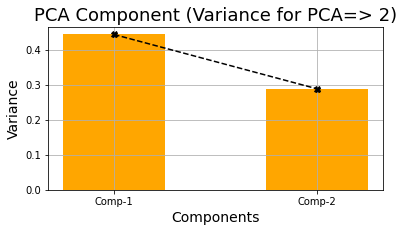

[0.44389445 0.28870686 0.17465543 0.04766964]


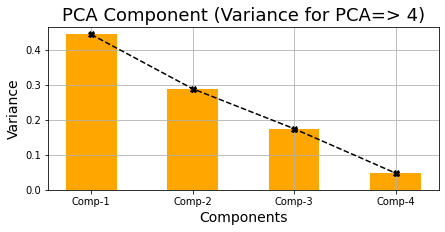

[0.44389445 0.28870686 0.17465543 0.04766964 0.02966127 0.006242  ]


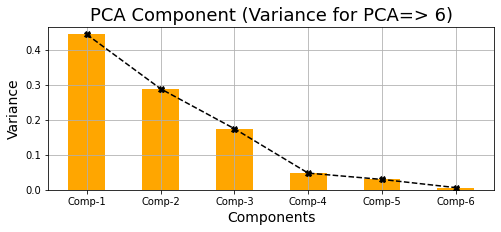

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,CANCELLED
0,0.0,-1.62228,-1.67413,0.036734,-1.242252,-1.181000,-0.657950,-0.952644,1.156696,-2.738186,...,-2.046451,-0.678581,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
1,0.0,-1.62228,-1.67413,0.036734,-1.458026,0.092716,-0.704169,0.337404,0.816000,-2.727850,...,-1.408665,-0.344520,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
2,0.0,-1.62228,-1.67413,0.036734,0.915486,-0.758705,-1.498992,1.164981,-0.554893,-2.707179,...,-1.274596,0.015237,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
3,0.0,-1.62228,-1.67413,0.036734,-1.458026,-1.089939,-0.732180,0.337404,0.556423,-2.707179,...,-1.379936,-0.344520,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
4,0.0,-1.62228,-1.67413,0.036734,-1.242252,-1.159942,-0.301505,1.156868,-0.952372,-2.696843,...,-2.331826,-0.652884,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
5,0.0,-1.62228,-1.67413,0.036734,-0.810704,-0.778055,-0.994787,1.164981,0.661876,-2.696843,...,-1.659566,0.092328,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
6,0.0,-1.62228,-1.67413,0.036734,0.268164,-0.888467,0.142476,0.321177,0.661876,-2.696843,...,-1.853008,-0.550096,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
7,0.0,-1.62228,-1.67413,0.036734,0.915486,-0.091114,-0.106125,0.337404,-0.554893,-2.686507,...,-1.385682,-0.370217,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
8,0.0,-1.62228,-1.67413,0.036734,-1.458026,-0.603901,-0.700667,1.164981,-0.392658,-2.686507,...,-1.808957,-0.447308,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0
9,0.0,-1.62228,-1.67413,0.036734,-0.810704,-0.569184,0.961109,0.321177,-0.928036,-2.686507,...,-1.571463,-0.498702,-0.051154,0.019366,5.935348e-16,3.029047e-17,-1.725560e-16,-9.619389e-16,2.541979e-16,0


In [12]:
out_pc=[]
out_pc.append(chkoutlr(le_data.drop('CANCELLED',axis=1),2,6,3,"#FFA600"))
out_pc.append(chkoutlr(le_data.drop('CANCELLED',axis=1),4,7,3,"#FFA600"))
out_pc.append(chkoutlr(le_data.drop('CANCELLED',axis=1),6,8,3,"#FFA600"))
mnv=[]
for opc in out_pc:
  mnv.append(opc.mean())
mnv.sort()
crit=mnv[-1]
valstr=[]
outflag=[]
for opc in out_pc:
  for p in opc:
    if p>crit:
        outflag.append(True)
if len(outflag)==3 and True in outflag:
    le_norm_data=normalize_data(le_data.drop('CANCELLED',axis=1))
le_norm_data=pandas.DataFrame(le_norm_data,columns=le_data.drop('CANCELLED',axis=1).columns.tolist())
le_norm_data['CANCELLED']=le_data['CANCELLED']
le_norm_data.head(10)

[0.17620881 0.14801169]


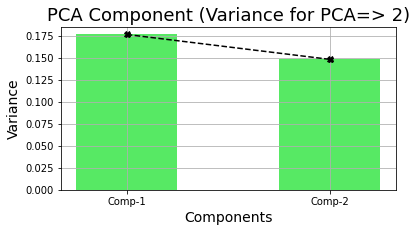

[0.17620878 0.14801165 0.08634999 0.06001774]


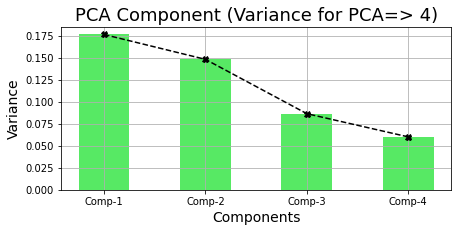

[0.17620879 0.14801164 0.08635014 0.06005023 0.05176391 0.03945142]


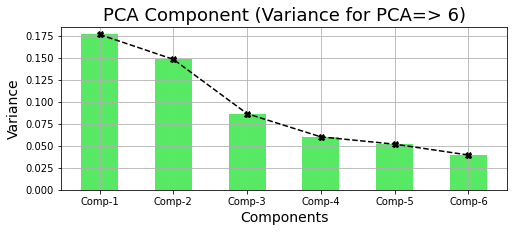

array([0.17620879, 0.14801164, 0.08635014, 0.06005023, 0.05176391,
       0.03945142])

In [13]:
chkoutlr(le_norm_data.drop('CANCELLED',axis=1),2,6,3,"#57E964")
chkoutlr(le_norm_data.drop('CANCELLED',axis=1),4,7,3,"#57E964")
chkoutlr(le_norm_data.drop('CANCELLED',axis=1),6,8,3,"#57E964")

In [14]:
def datavz(fl, ft):
  t10=fl[ft].value_counts()[:10]
  ct=t10.index.tolist()
  vl=t10.tolist()
  t10df=pandas.DataFrame({
      "{}".format(ft):ct,
      "Count":vl
  })
  vzcl=["#0020C2","#00BFFF","#728C00","#FFD700","#7FE817","#FFFF00","#FF6700","#B3446C","#FF1493","#9400D3"]
  if "_" in ft:
    nm=' '.join(ft.split("_"))
  else:
    nm=ft.capitalize()
  t10df=t10df[::-1]
  mpl.figure(figsize=(6,4))
  mpl.title("Top Listed {}".format(nm),fontsize=16)
  mpl.barh(t10df["{}".format(ft)],t10df['Count'],color=vzcl)
  mpl.xlabel("Regressor",fontsize=13)
  mpl.ylabel("{}".format(nm),fontsize=13)
  for id_tt, va_tt in enumerate(t10df['Count']):
      mpl.text(va_tt, id_tt, str(va_tt))
  mpl.grid()
  mpl.show()

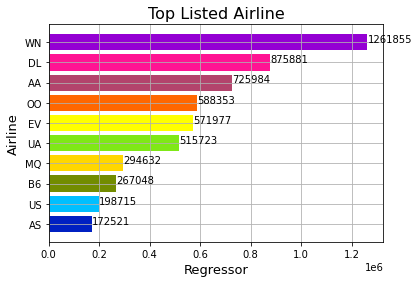

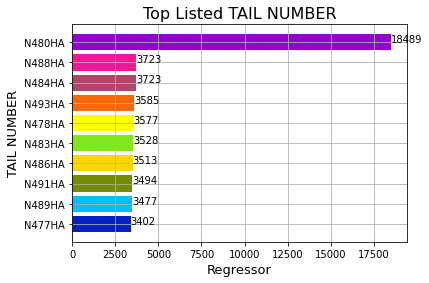

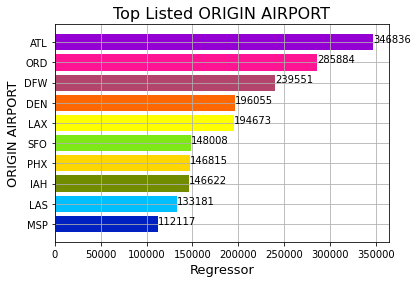

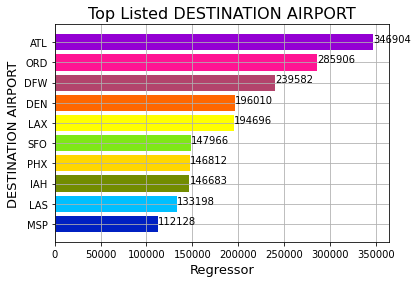

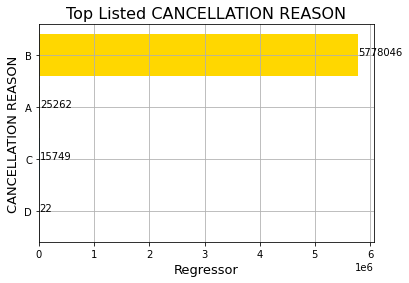

In [15]:
cln_data_vz=cln_data.copy()
ctdt=cln_data_vz.dtypes[cln_data_vz.dtypes=='object'].index.tolist()
for col in ctdt:
  datavz(cln_data,col)

## Big Data Analytics and Flight Delay Prediction

### Big Data

In [16]:
le_norm_data1=utils.resample(le_norm_data, replace = True, n_samples = int(len(le_norm_data)/10), random_state = 0)
flight_sp = spark.createDataFrame(le_norm_data1)
flight_sp.show()

+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|YEAR|               MONTH|                 DAY|        DAY_OF_WEEK|             AIRLINE|       FLIGHT_NUMBER|         TAIL_NUMBER|      ORIGIN_AIRPORT| DESTINATION_AIRPORT| SCHEDULED_DEPARTURE|      DEPARTURE_TIME|     DEPARTURE_DELAY|            TAXI_OUT|          WHEELS_OFF|      SCHEDULED_TIME|        ELAPSED_TIME|            AIR_TIME|            DISTANCE|           WHEEL

### Information of Data Features

In [17]:
flight_sp.printSchema()

root
 |-- YEAR: double (nullable = true)
 |-- MONTH: double (nullable = true)
 |-- DAY: double (nullable = true)
 |-- DAY_OF_WEEK: double (nullable = true)
 |-- AIRLINE: double (nullable = true)
 |-- FLIGHT_NUMBER: double (nullable = true)
 |-- TAIL_NUMBER: double (nullable = true)
 |-- ORIGIN_AIRPORT: double (nullable = true)
 |-- DESTINATION_AIRPORT: double (nullable = true)
 |-- SCHEDULED_DEPARTURE: double (nullable = true)
 |-- DEPARTURE_TIME: double (nullable = true)
 |-- DEPARTURE_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- SCHEDULED_TIME: double (nullable = true)
 |-- ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- SCHEDULED_ARRIVAL: double (nullable = true)
 |-- ARRIVAL_TIME: double (nullable = true)
 |-- ARRIVAL_DELAY: double (nullable = true)
 |-- D

In [91]:
feature_columns = [col for col in flight_sp.columns]
print(feature_columns)

['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'CANCELLED']


In [92]:
vctflight = VectorAssembler(inputCols = feature_columns, outputCol="features")
vctflight.transform(flight_sp).select("features", "CANCELLED").limit(10).toPandas()

,features,CANCELLED
0,"[0.0, 1.0207857438275383, -0.8771742885247861,...",0
1,"[0.0, -0.7412581382598097, -1.1048759147074343...",0
2,"[0.0, -0.44758415791191836, 0.602886281662427,...",0
3,"[0.0, 1.3144597241754294, 0.37518465547977875,...",0
4,"[0.0, -0.44758415791191836, 0.8305879078450751...",0
5,"[0.0, -0.44758415791191836, 0.602886281662427,...",0
6,"[0.0, -1.6222800793034837, 1.0582895340277232,...",0
7,"[0.0, -0.15391017756402706, 1.2859911602103713...",0
8,"[0.0, 1.3144597241754294, -1.3325775408900824,...",0
9,"[0.0, -1.6222800793034837, 0.602886281662427, ...",0


In [93]:
trflight, tsflight = flight_sp.randomSplit(weights=[0.7, 0.3], seed = 1)
tsflight.toPandas()['CANCELLED'].value_counts()

0    171744
1      2622
Name: CANCELLED, dtype: int64

In [94]:
def model_evaluate():
  eac = MulticlassClassificationEvaluator(labelCol="CANCELLED", predictionCol="prediction", metricName="accuracy")
  ef1 = MulticlassClassificationEvaluator(labelCol="CANCELLED", predictionCol="prediction", metricName="f1")
  return eac, ef1

In [95]:
def getclf(lbl):
  m1=LogisticRegression(featuresCol='features',labelCol=lbl)
  m2=GBTClassifier(featuresCol='features',labelCol=lbl)
  m3=RandomForestClassifier(featuresCol='features',labelCol=lbl)
  return m1,m2,m3

In [96]:
def getpip(vct,trd,mdl):
  ppln = Pipeline()
  ppln.setStages([vct, mdl])
  mdpip = ppln.fit(trd)
  return mdpip

In [97]:
allclf=getclf("CANCELLED")
nms=["Logistic Regression","GBT Classifier","Random forest classifier"]
print(allclf[0])
print(allclf[1])
print(allclf[2])

LogisticRegression_a6d9273b123c
GBTClassifier_525c54e3ce9c
RandomForestClassifier_8626c7976eaf


In [98]:
allmet=[[],[],[],[]]
print("=======================================================")
for ac in range(len(allclf)):
  print("Prediction using {} Model.".format(nms[ac]))
  t1 = datetime.datetime.now()
  print('Start time({}):'.format(nms[ac]), t1.time()) 
  model=getpip(vctflight, trflight, allclf[ac])
  eac, ef1=model_evaluate()
  accuracyts = eac.evaluate(model.transform(tsflight))
  accuracytr = eac.evaluate(model.transform(trflight))
  f1score = ef1.evaluate(model.transform(tsflight))
  t2 = datetime.datetime.now()
  print('End time:({}):'.format(nms[ac]), t2.time())
  delta = t2 - t1
  print("=======================================================")
  allmet[0].append(accuracyts)
  allmet[1].append(accuracytr)
  allmet[2].append(f1score)
  allmet[3].append(delta.total_seconds())

Prediction using Logistic Regression Model.
Start time(Logistic Regression): 07:00:20.954733
End time:(Logistic Regression): 07:00:53.002071
Prediction using GBT Classifier Model.
Start time(GBT Classifier): 07:00:53.002276
End time:(GBT Classifier): 07:02:04.372227
Prediction using Random forest classifier Model.
Start time(Random forest classifier): 07:02:04.372459
End time:(Random forest classifier): 07:02:34.642179


In [99]:
allmet

[[1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [32.047338, 71.369951, 30.26972]]

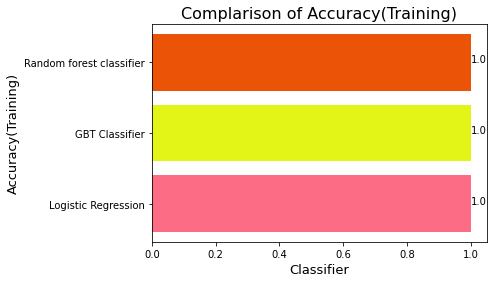

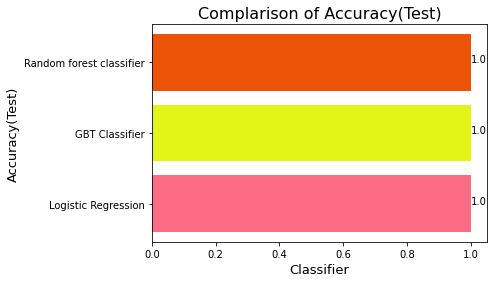

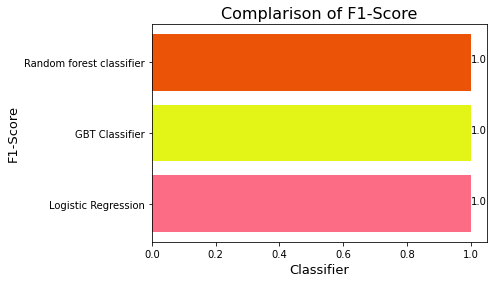

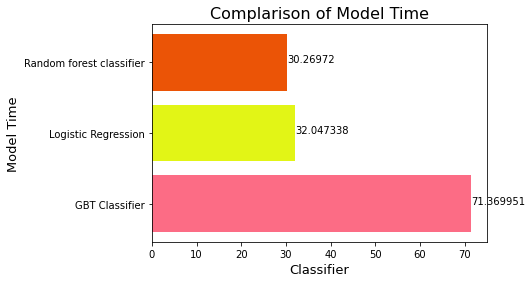

,Classifier,Accuracy(Training),Accuracy(Test),F1-Score,Model Time
1,GBT Classifier,1.0,1.0,1.0,71.369951
0,Logistic Regression,1.0,1.0,1.0,32.047338
2,Random forest classifier,1.0,1.0,1.0,30.269720


In [101]:
flgt_df=pandas.DataFrame({
    "Classifier":nms,
    "Accuracy(Training)":allmet[1],
    "Accuracy(Test)":allmet[0],
    "F1-Score":allmet[2],
    "Model Time":allmet[3]
})
metsvz=flgt_df.columns.tolist()[1:]
for m in metsvz:
    flgt_df=flgt_df.sort_values(by=m,ascending=False)
    mpl.figure(figsize=(6,4))
    mpl.title("Complarison of {}".format(m),fontsize=16)
    mpl.barh(flgt_df['Classifier'],flgt_df[m],color=["#FC6C85","#E2F516","#EB5406"])
    mpl.xlabel("Classifier",fontsize=13)
    mpl.ylabel("{}".format(m),fontsize=13)
    for flgt_id, flgt_val in enumerate(flgt_df[m]):
        mpl.text(flgt_val, flgt_id, str(flgt_val))
    mpl.show()
flgt_df.to_csv("Result_metrics.csv")
flgt_df